<a href="https://colab.research.google.com/github/660710078/TopGun2025/blob/main/Pre2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Setup & Installation

In [1]:
# ติดตั้ง libraries ที่จำเป็น
!pip install ultralytics
!pip install opencv-python-headless
!pip install numpy pandas matplotlib

# Import libraries
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow
import math

# Mount Google Drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


Step 2: Dataset Setup

In [2]:
# กำหนด path
base_path = '/content/drive/MyDrive/drone_dataset'
yaml_path = f'{base_path}/data.yaml'

# ตรวจสอบโครงสร้าง dataset
!ls -la {base_path}

total 9
-rw------- 1 root root  113 Oct 27 04:37 data.yaml
drwx------ 2 root root 4096 Oct 27 03:59 train
drwx------ 2 root root 4096 Oct 27 03:59 valid


Step 3: Train YOLOv8 Model

In [3]:
# โหลด YOLOv8 model
model = YOLO('yolov8n.pt')  # n=nano, s=small, m=medium, l=large, x=xlarge

# Train model
results = model.train(
    data=yaml_path,
    epochs=50,  # ปรับตามความต้องการ
    imgsz=640,
    batch=16,
    name='drone_detection',
    patience=10,  # Early stopping
    save=True,
    plots=True
)

# บันทึก trained model
model.save(f'{base_path}/best_drone_model.pt')

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/drone_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=drone_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspect

Step 4: Image Processing Functions
* ✅ เพิ่มความแม่นยำในการตรวจจับ
* ✅ ทำงานได้ดีในสภาพแสงต่างๆ
* ✅ ลด false positive



In [4]:
class DroneImageProcessor:
    """ประมวลผลภาพก่อนส่งเข้า YOLO"""

    @staticmethod
    def enhance_image(image):
        """
        ปรับปรุงคุณภาพภาพ
        - เพิ่ม contrast
        - ลด noise
        - ปรับความสว่าง
        """
        # แปลงเป็น LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # ใช้ CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l = clahe.apply(l)

        # รวม channels กลับ
        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

        # ลด noise ด้วย bilateral filter
        enhanced = cv2.bilateralFilter(enhanced, 9, 75, 75)

        return enhanced

    @staticmethod
    def sharpen_image(image):
        """เพิ่มความคมชัด"""
        kernel = np.array([[-1,-1,-1],
                          [-1, 9,-1],
                          [-1,-1,-1]])
        sharpened = cv2.filter2D(image, -1, kernel)
        return sharpened

    @staticmethod
    def adaptive_threshold_preprocessing(image):
        """สำหรับสภาพแสงที่ยาก"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        adaptive = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )
        return cv2.cvtColor(adaptive, cv2.COLOR_GRAY2BGR)

Step 5: Angle Detection System
* คำนวณมุมจากตำแหน่งใน frame
* ประมาณระยะทางจากขนาด bounding box
* แสดงผลแบบเข้าใจง่าย

In [5]:
class AngleDetector:
    """คำนวณมุมของ drone"""

    def __init__(self, frame_height, frame_width):
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.center_y = frame_height // 2
        self.center_x = frame_width // 2

    def calculate_angle(self, bbox):
        """
        คำนวณมุมราบและมุมเงย/ก้ม

        Returns:
            horizontal_angle: มุมราบ (-180 ถึง 180 องศา)
            vertical_angle: มุมเงย/ก้ม (บวก=เงย, ลบ=ก้ม)
        """
        x1, y1, x2, y2 = bbox

        # หาจุดกึ่งกลาง bounding box
        drone_center_x = (x1 + x2) / 2
        drone_center_y = (y1 + y2) / 2

        # คำนวณระยะห่างจากจุดกึ่งกลางเฟรม
        delta_x = drone_center_x - self.center_x
        delta_y = self.center_y - drone_center_y  # กลับทิศเพราะ y เพิ่มลงล่าง

        # คำนวณมุมราบ (horizontal)
        horizontal_angle = math.degrees(math.atan2(delta_x, self.frame_width/2)) * 2

        # คำนวณมุมเงย/ก้ม (vertical)
        vertical_angle = math.degrees(math.atan2(delta_y, self.frame_height/2)) * 2

        # ประเมินมุมตาม position และขนาด
        bbox_area = (x2 - x1) * (y2 - y1)
        frame_area = self.frame_height * self.frame_width
        size_ratio = bbox_area / frame_area

        return {
            'horizontal': round(horizontal_angle, 2),
            'vertical': round(vertical_angle, 2),
            'position': self._get_position(horizontal_angle, vertical_angle),
            'distance_estimate': self._estimate_distance(size_ratio)
        }

    def _get_position(self, h_angle, v_angle):
        """บอกตำแหน่งของ drone"""
        h_pos = "กลาง"
        if h_angle < -20:
            h_pos = "ซ้าย"
        elif h_angle > 20:
            h_pos = "ขวา"

        v_pos = "ระดับสายตา"
        if v_angle > 20:
            v_pos = "เงย"
        elif v_angle < -20:
            v_pos = "ก้ม"

        return f"{v_pos} {h_pos}"

    def _estimate_distance(self, size_ratio):
        """ประมาณระยะทาง"""
        if size_ratio > 0.15:
            return "ใกล้มาก"
        elif size_ratio > 0.08:
            return "ใกล้"
        elif size_ratio > 0.03:
            return "กลาง"
        else:
            return "ไกล"

Step 6: Tracking System with Centroid
* คำนวณ centroid ของทุก detection
* เปรียบเทียบกับ objects ที่ track อยู่
* Match ด้วยระยะห่างที่ใกล้ที่สุด
* เก็บ trajectory (เส้นทาง)

In [6]:
class CentroidTracker:
    """
    ติดตาม drone ด้วย centroid tracking
    - ใช้ระยะห่าง Euclidean เพื่อ match objects
    """

    def __init__(self, max_disappeared=30):
        self.next_object_id = 0
        self.objects = {}  # {object_id: centroid}
        self.disappeared = {}  # นับจำนวนครั้งที่หายไป
        self.max_disappeared = max_disappeared
        self.trajectory = {}  # เก็บเส้นทาง

    def register(self, centroid):
        """ลงทะเบียน object ใหม่"""
        self.objects[self.next_object_id] = centroid
        self.disappeared[self.next_object_id] = 0
        self.trajectory[self.next_object_id] = [centroid]
        self.next_object_id += 1

    def deregister(self, object_id):
        """ลบ object ที่หายไปนาน"""
        del self.objects[object_id]
        del self.disappeared[object_id]
        del self.trajectory[object_id]

    def update(self, detections):
        """
        อัพเดท tracking

        Args:
            detections: list of bounding boxes [[x1,y1,x2,y2], ...]
        """
        # ถ้าไม่มี detection
        if len(detections) == 0:
            for object_id in list(self.disappeared.keys()):
                self.disappeared[object_id] += 1

                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)

            return self.objects

        # คำนวณ centroid ของ detection ใหม่
        input_centroids = np.zeros((len(detections), 2), dtype="int")
        for i, (x1, y1, x2, y2) in enumerate(detections):
            cX = int((x1 + x2) / 2.0)
            cY = int((y1 + y2) / 2.0)
            input_centroids[i] = (cX, cY)

        # ถ้ายังไม่มี object ที่ track
        if len(self.objects) == 0:
            for centroid in input_centroids:
                self.register(centroid)
        else:
            # Match detection กับ existing objects
            object_ids = list(self.objects.keys())
            object_centroids = list(self.objects.values())

            # คำนวณระยะห่าง
            D = np.zeros((len(object_centroids), len(input_centroids)))
            for i, obj_centroid in enumerate(object_centroids):
                for j, input_centroid in enumerate(input_centroids):
                    D[i, j] = np.linalg.norm(
                        np.array(obj_centroid) - np.array(input_centroid)
                    )

            # หา minimum distance pairs
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            used_rows = set()
            used_cols = set()

            for (row, col) in zip(rows, cols):
                if row in used_rows or col in used_cols:
                    continue

                # Update object
                object_id = object_ids[row]
                self.objects[object_id] = input_centroids[col]
                self.disappeared[object_id] = 0
                self.trajectory[object_id].append(tuple(input_centroids[col]))

                # เก็บแค่ 50 จุดล่าสุด
                if len(self.trajectory[object_id]) > 50:
                    self.trajectory[object_id].pop(0)

                used_rows.add(row)
                used_cols.add(col)

            # หา unused rows/cols
            unused_rows = set(range(D.shape[0])) - used_rows
            unused_cols = set(range(D.shape[1])) - used_cols

            # จัดการ disappeared objects
            for row in unused_rows:
                object_id = object_ids[row]
                self.disappeared[object_id] += 1

                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)

            # ลงทะเบียน detection ใหม่
            for col in unused_cols:
                self.register(input_centroids[col])

        return self.objects

Step 7: Video Processing & Visualization

In [7]:
class DroneDetectionSystem:
    """ระบบหลักสำหรับ detect และ track drone"""

    def __init__(self, model_path, confidence=0.5):
        self.model = YOLO(model_path)
        self.confidence = confidence
        self.processor = DroneImageProcessor()
        self.tracker = CentroidTracker(max_disappeared=30)

        # สำหรับ visualization
        self.colors = {}

    def get_color(self, object_id):
        """สร้างสีสำหรับแต่ละ object"""
        if object_id not in self.colors:
            self.colors[object_id] = (
                np.random.randint(0, 255),
                np.random.randint(0, 255),
                np.random.randint(0, 255)
            )
        return self.colors[object_id]

    def process_video(self, video_path, output_path=None,
                     use_enhancement=True, show_trajectory=True):
        """
        ประมวลผลวิดีโอ

        Args:
            video_path: path ของวิดีโอ
            output_path: path สำหรับบันทึก (ถ้าไม่ระบุจะไม่บันทึก)
            use_enhancement: ใช้ image processing หรือไม่
            show_trajectory: แสดงเส้นทางหรือไม่
        """
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print("❌ ไม่สามารถเปิดวิดีโอได้")
            return

        # รับข้อมูลวิดีโอ
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # สร้าง angle detector
        angle_detector = AngleDetector(frame_height, frame_width)

        # เตรียม video writer
        writer = None
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(
                output_path, fourcc, fps,
                (frame_width, frame_height)
            )

        frame_count = 0
        detection_count = 0

        print(f"🎬 เริ่มประมวลผลวิดีโอ...")
        print(f"📊 ขนาด: {frame_width}x{frame_height} | FPS: {fps} | Frames: {total_frames}")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Image enhancement (ถ้าเปิดใช้)
            processed_frame = frame.copy()
            if use_enhancement:
                processed_frame = self.processor.enhance_image(processed_frame)

            # Detect drones
            results = self.model(processed_frame, conf=self.confidence, verbose=False)

            # เก็บ detections
            detections = []
            detection_info = []

            for result in results:
                boxes = result.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    conf = float(box.conf[0])
                    cls = int(box.cls[0])

                    detections.append([x1, y1, x2, y2])
                    detection_info.append({
                        'bbox': [x1, y1, x2, y2],
                        'confidence': conf,
                        'class': cls
                    })

            # Update tracker
            objects = self.tracker.update(detections)

            # วาด visualization
            for object_id, centroid in objects.items():
                # หา bbox ที่ตรงกับ centroid
                matched_info = None
                min_dist = float('inf')

                for info in detection_info:
                    bbox = info['bbox']
                    bbox_centroid = (
                        (bbox[0] + bbox[2]) // 2,
                        (bbox[1] + bbox[3]) // 2
                    )
                    dist = np.linalg.norm(
                        np.array(centroid) - np.array(bbox_centroid)
                    )
                    if dist < min_dist:
                        min_dist = dist
                        matched_info = info

                if matched_info is None:
                    continue

                detection_count += 1
                color = self.get_color(object_id)
                bbox = matched_info['bbox']
                x1, y1, x2, y2 = bbox

                # คำนวณมุม
                angle_info = angle_detector.calculate_angle(bbox)

                # วาด bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

                # วาด centroid
                cv2.circle(frame, centroid, 5, color, -1)

                # แสดง ID และข้อมูล
                label = f"ID:{object_id} | {matched_info['confidence']:.2f}"
                cv2.putText(frame, label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # แสดงมุม
                angle_text = f"H:{angle_info['horizontal']:.1f}° V:{angle_info['vertical']:.1f}°"
                cv2.putText(frame, angle_text, (x1, y2+20),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # แสดงตำแหน่ง
                position_text = f"{angle_info['position']} | {angle_info['distance_estimate']}"
                cv2.putText(frame, position_text, (x1, y2+40),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # วาด trajectory
                if show_trajectory and object_id in self.tracker.trajectory:
                    points = self.tracker.trajectory[object_id]
                    for i in range(1, len(points)):
                        cv2.line(frame, points[i-1], points[i], color, 2)

            # แสดงข้อมูลทั่วไป
            info_text = f"Frame: {frame_count}/{total_frames} | Drones: {len(objects)}"
            cv2.putText(frame, info_text, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # วาดกากบาทตรงกลาง (จุดอ้างอิง)
            center_x, center_y = frame_width // 2, frame_height // 2
            cv2.drawMarker(frame, (center_x, center_y),
                          (0, 255, 255), cv2.MARKER_CROSS, 20, 2)

            # บันทึก frame
            if writer:
                writer.write(frame)

            # แสดงความคืบหน้า
            if frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"⏳ ประมวลผล: {progress:.1f}% | Detections: {detection_count}")

        # ปิดทุกอย่าง
        cap.release()
        if writer:
            writer.release()

        print(f"\n✅ เสร็จสิ้น!")
        print(f"📊 สถิติ:")
        print(f"   - Total frames: {frame_count}")
        print(f"   - Total detections: {detection_count}")
        print(f"   - Unique drones tracked: {len(self.colors)}")

        if output_path:
            print(f"💾 บันทึกที่: {output_path}")

Step 8: Run Detection (Demo)

In [8]:
# โหลด trained model
model_path = f'{base_path}/best_drone_model.pt'

# หรือใช้ pretrained model (ถ้ายังไม่ train)
# model_path = 'yolov8n.pt'

# สร้างระบบ
detector = DroneDetectionSystem(
    model_path=model_path,
    confidence=0.5  # ความมั่นใจขั้นต่ำ
)

# ทดสอบกับวิดีโอ
video_path = '/content/cam0.mp4'
output_path = '/content/drive/MyDrive/output_detected.mp4'

detector.process_video(
    video_path=video_path,
    output_path=output_path,
    use_enhancement=True,  # ใช้ image processing
    show_trajectory=True    # แสดงเส้นทาง
)

🎬 เริ่มประมวลผลวิดีโอ...
📊 ขนาด: 1920x1080 | FPS: 29 | Frames: 5334
⏳ ประมวลผล: 0.6% | Detections: 28
⏳ ประมวลผล: 1.1% | Detections: 58
⏳ ประมวลผล: 1.7% | Detections: 87
⏳ ประมวลผล: 2.2% | Detections: 112
⏳ ประมวลผล: 2.8% | Detections: 133
⏳ ประมวลผล: 3.4% | Detections: 161
⏳ ประมวลผล: 3.9% | Detections: 185
⏳ ประมวลผล: 4.5% | Detections: 215
⏳ ประมวลผล: 5.1% | Detections: 245
⏳ ประมวลผล: 5.6% | Detections: 275
⏳ ประมวลผล: 6.2% | Detections: 305
⏳ ประมวลผล: 6.7% | Detections: 335
⏳ ประมวลผล: 7.3% | Detections: 365
⏳ ประมวลผล: 7.9% | Detections: 393
⏳ ประมวลผล: 8.4% | Detections: 415
⏳ ประมวลผล: 9.0% | Detections: 432
⏳ ประมวลผล: 9.6% | Detections: 435
⏳ ประมวลผล: 10.1% | Detections: 451
⏳ ประมวลผล: 10.7% | Detections: 478
⏳ ประมวลผล: 11.2% | Detections: 507
⏳ ประมวลผล: 11.8% | Detections: 536
⏳ ประมวลผล: 12.4% | Detections: 565
⏳ ประมวลผล: 12.9% | Detections: 585
⏳ ประมวลผล: 13.5% | Detections: 602
⏳ ประมวลผล: 14.1% | Detections: 630
⏳ ประมวลผล: 14.6% | Detections: 648
⏳ ประมวลผล: 15.2

Step 9: Evaluation & Visualization

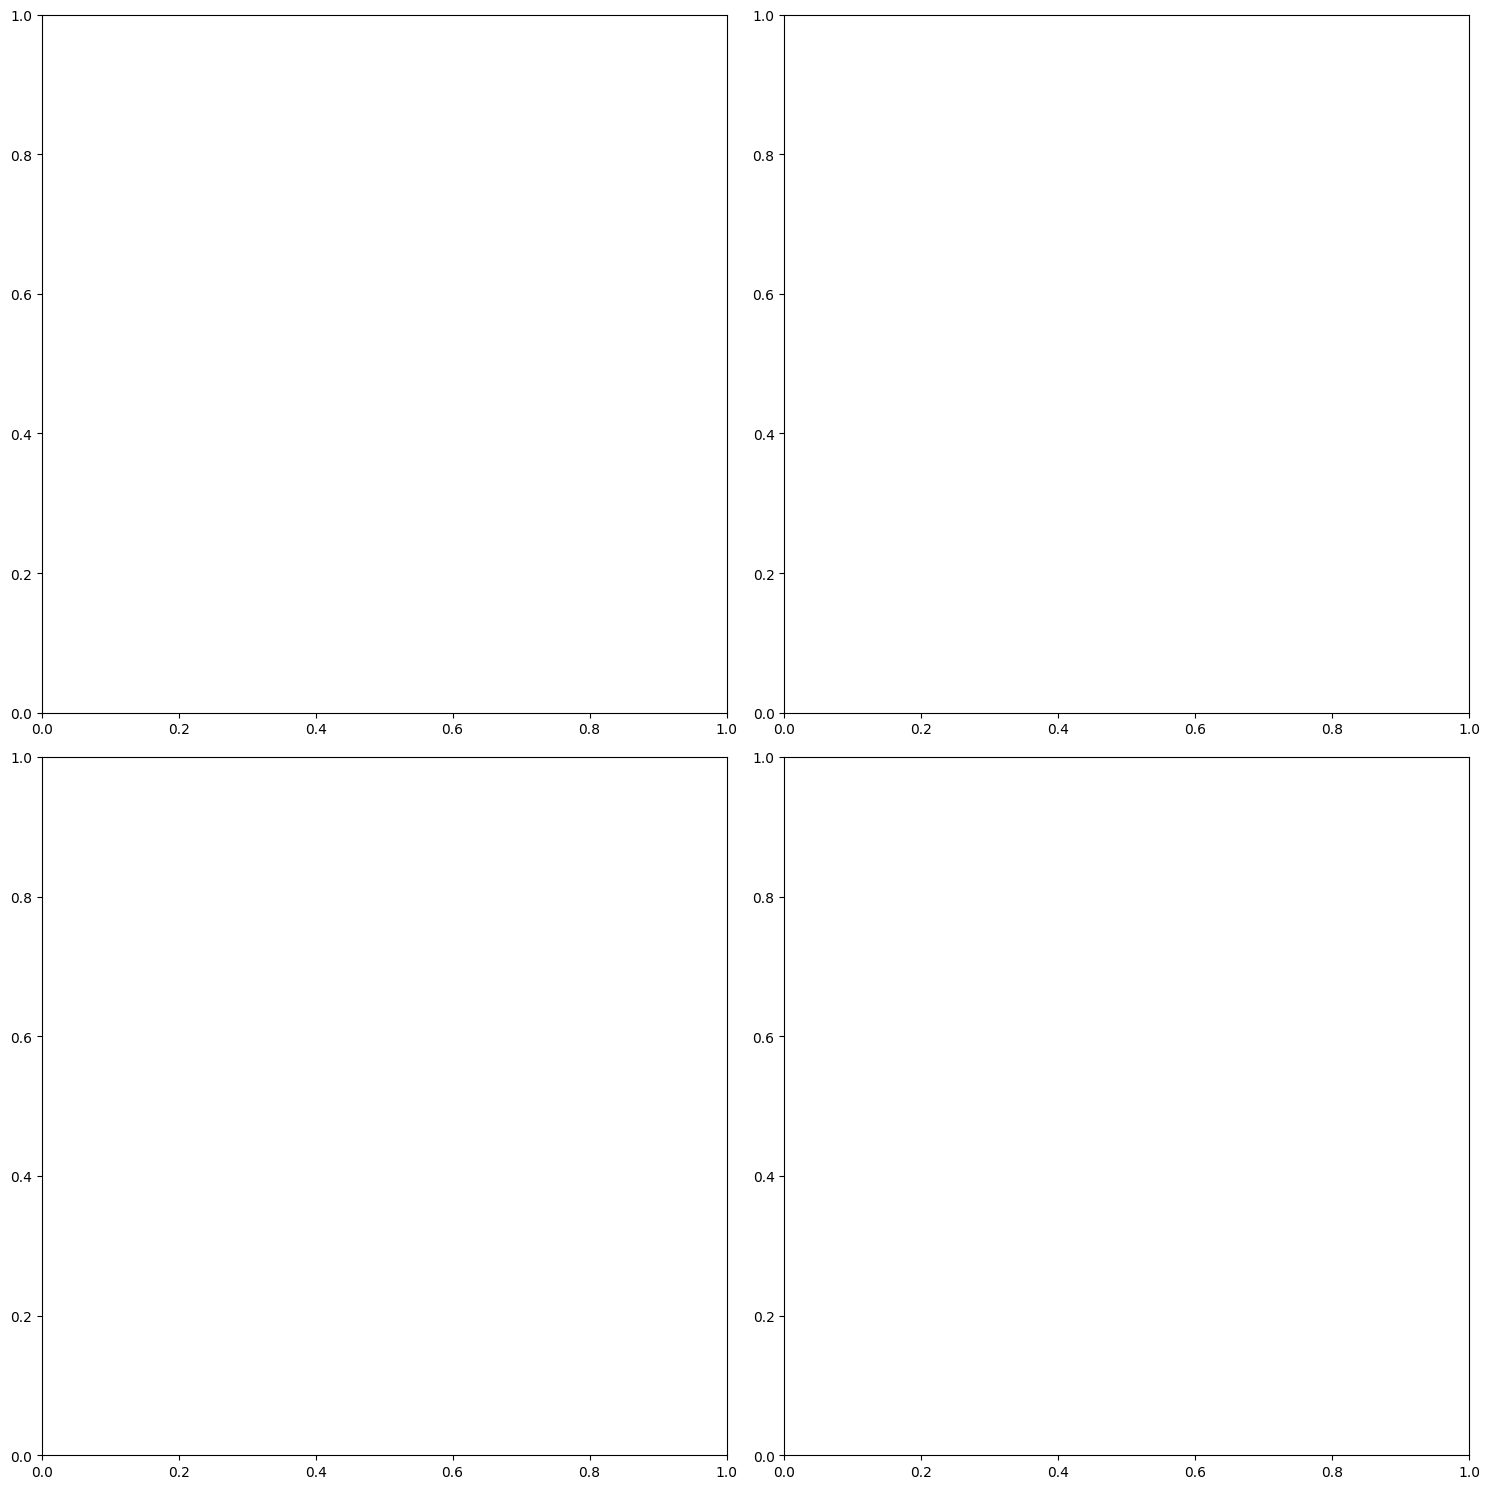

In [9]:
def show_sample_detections(image_folder, model, num_samples=4):
    """แสดงตัวอย่างการ detect"""
    import glob
    import random

    images = glob.glob(f"{image_folder}/*.jpg") + glob.glob(f"{image_folder}/*.png")
    samples = random.sample(images, min(num_samples, len(images)))

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()

    processor = DroneImageProcessor()

    for idx, img_path in enumerate(samples):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Enhance image
        enhanced = processor.enhance_image(img)

        # Detect
        results = model(enhanced, conf=0.5)

        # วาด results
        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])

                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img_rgb, f'{conf:.2f}', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        axes[idx].imshow(img_rgb)
        axes[idx].axis('off')
        axes[idx].set_title(f'Detection {idx+1}')

    plt.tight_layout()
    plt.savefig(f'{base_path}/sample_detections.png', dpi=150, bbox_inches='tight')
    plt.show()

# เรียกใช้
show_sample_detections(f'{base_path}/test/images', model)

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


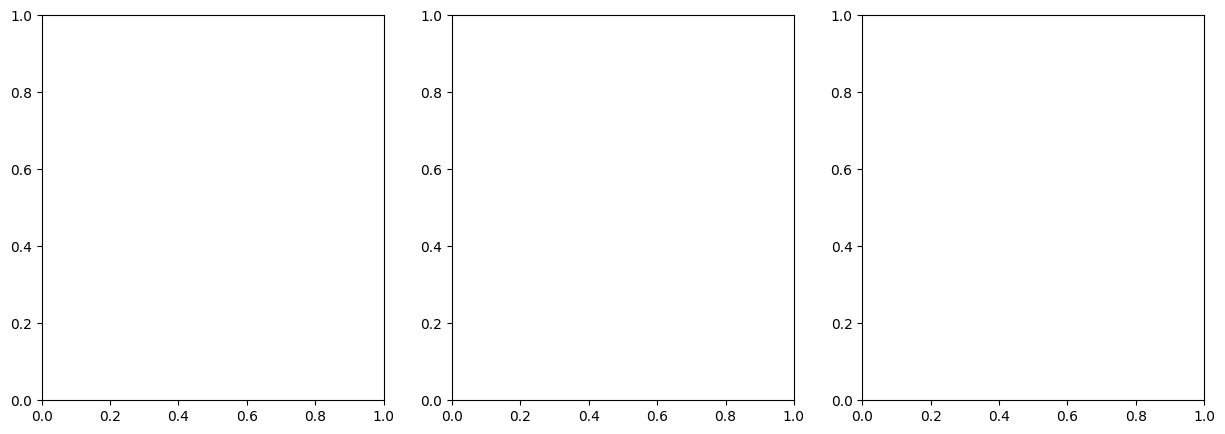

In [11]:
# 1. ทดสอบกับภาพนิ่งก่อน
def quick_test_image(image_path):
    img = cv2.imread(image_path)
    results = model(img, conf=0.5)
    results[0].plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 2. ปรับ confidence threshold
detector.confidence = 0.3  # ลดถ้าต้องการ detect มากขึ้น

# 3. ทดสอบ enhancement
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
img = cv2.imread('test.jpg')
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[1].imshow(cv2.cvtColor(processor.enhance_image(img), cv2.COLOR_BGR2RGB))
axes[1].set_title('Enhanced')
axes[2].imshow(cv2.cvtColor(processor.sharpen_image(img), cv2.COLOR_BGR2RGB))
axes[2].set_title('Sharpened')
plt.show()